# Model Prediction

In [1]:
from transformers import AutoTokenizer, BertForTokenClassification # Import AutoTokenizer and BertForTokenClassification from the transformers library for NLP tasks.
import torch # Import the PyTorch library for tensor computations and deep learning.
import numpy as np # Import NumPy for numerical operations and array manipulations.
import argparse # Import argparse for parsing command-line arguments.
from typing import List # Import List from the typing module for type annotations.
from config import Config # Import Config class from the config module, used for loading and accessing configuration settings.
# Import utility functions: read_labels (to read label data), get_label_map and get_inv_label_map (for mapping labels to indices and vice versa).
from utils import read_labels, get_label_map, get_inv_label_map
import argparse # Re-import argparse (duplicate import, not necessary).
import sys # Import sys for interacting with the Python interpreter (e.g., command-line arguments, system exit).
import dill

/home/mke37/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
sentences = []
labels = []

curr_sentence = []
curr_labels = []

with open("TestingData.txt", "r") as file:
    for line in file:
        if line != "\n":
            label = line.split()[0]
            word = line.split()[1]
            
            curr_sentence.append(word)
            curr_labels.append(label)
        else:
            sentences.append(curr_sentence)
            labels.append(curr_labels)
            curr_sentence = []
            curr_labels = []
            
print("DONE!")           

DONE!


In [3]:
class NERPredictor:
    def __init__(self, model_path: str):
        self.cfg = Config() # Initialize and load configuration settings from the Config class.
        
        # Read the label list from the specified file path.
        self.label_list = read_labels('NewEntities.txt')
        # Create mappings from labels to indices and vice versa.
        self.label_map = get_label_map(self.label_list)
        self.inv_label_map = get_inv_label_map(self.label_list)

        # Load the pre-trained BERT model for token classification.
        self.model = BertForTokenClassification.from_pretrained(
            self.cfg.MODEL_NAME,
            return_dict=True,
            num_labels=len(self.label_map),
            output_attentions=False,
            output_hidden_states=False
        )

        # Load the saved model weights.
        self.model.load_state_dict(torch.load(model_path, map_location='cpu'))
        # Load the tokenizer associated with the pre-trained BERT model.
        self.tokenizer = AutoTokenizer.from_pretrained(self.cfg.MODEL_NAME)

    def predict(self, sentences: str) -> List[str]:
        
        foundDecimal = False
        
        # Tokenize the input sentence to get input IDs.
        input_ids = self.tokenizer.encode(sentences, return_tensors='pt')
        # print(len(input_ids[0]), input_ids)
        with torch.no_grad(): # Disable gradient calculations for inference.
            self.model.to('cpu') # Ensure the model is on CPU for inference.
            # Get model predictions for the input IDs.
            output = self.model(input_ids)

        # Convert model logits to label indices.
        label_indices = np.argmax(output.logits.to('cpu').numpy(), axis=2)
        # Convert input IDs back to tokens.
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

        new_tokens, new_labels = [], []

        label_indices_0 = label_indices[0]
        for i in range(len(tokens)):
            token = tokens[i]
            label_idx = label_indices_0[i]
            # Merge subword tokens that start with "##".
            # print(token, label_idx, "DEBUG", i)
            
            if foundDecimal:
                # print("__________foundDecimal__________")
                token = "##" + tokens[i]
                foundDecimal = False
            if token.startswith(".") and tokens[i-1][-1].isdigit() and i != len(tokens)-2:
                # print("__________foundDecimal__________")
                foundDecimal = True
                token = "##" + tokens[i]
                
            if token == "%" or token == "٪" and i != 1:
                # print("________foundPercentage_________")
                token = "##" + tokens[i]
                
            if (token == "٬" or token == "٫") and (any(char.isdigit() for char in prev_token) and any(char.isdigit() for char in tokens[i+1])):
                # print("___________foundComma___________")
                token = "##" + tokens[i]
                foundDecimal = True
                            
            if token.startswith("##") :
                # print("_____________MERGE_______________")
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                if input_ids[0][i] == 2 or input_ids[0][i] == 3:
                    continue
                # Append the label for the token to new_labels.
                new_labels.append(self.inv_label_map[label_idx])
                # Append the token to new_tokens.
                new_tokens.append(token)
                
            prev_token = token
            
        # Return the list of labels corresponding to each token in the input.
        return new_labels
    
if __name__ == '__main__':
    predictor = NERPredictor(model_path='JuneModel_G.pt')

#     index = 320
    
#     predicted_labels = predictor.predict(' '.join(testSentences[index]))
#     print()
#     print(predicted_labels)
#     for token, label in zip(testSentences[index], predicted_labels):
#         print(label, token)
        
        
#     for i in range(0, len(testSentences[index])):
#         print(testSentences[index][i], predicted_labels[i])
        
#     for i in range(len(testSentences[index]), len(predicted_labels)):
#         print(predicted_labels[i])
        
#     print(len(predicted_labels))

    labelsPredictedArray = []
    for i in range(0, len(sentences)):
        predicted_labels = predictor.predict(' '.join(sentences[i]))
        labelsPredictedArray.append(predicted_labels)
        if i % 100 == 0:
            print(round((i/len(sentences)) * 100, 2), "%")
        
    print("100 %")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.0 %
11.68 %
23.36 %
35.05 %
46.73 %
58.41 %
70.09 %
81.78 %
93.46 %
100 %


In [4]:
index = 676
print("{:<20} {:<20} {:<20}".format("Predicted (" + str(len(labelsPredictedArray[index])) + ")", "Word", "True (" + str(len(labels[index])) + ")"))
print("--------------------------------------------------------")


for i in range(0, len(labels[index])):
    print("{:<20} {:<20} {:<20}".format(labelsPredictedArray[index][i], sentences[index][i], labels[index][i]))
for i in range(len(labels[index]), len(labelsPredictedArray[index])):
    print(labelsPredictedArray[index][i])


Predicted (58)       Word                 True (58)           
--------------------------------------------------------
OUTSIDE              وتقدر                OUTSIDE             
OUTSIDE              إستهلاكات            OUTSIDE             
OUTSIDE              الطاقة               OUTSIDE             
OUTSIDE              المتجددة             OUTSIDE             
OUTSIDE              في                   OUTSIDE             
B-Date               عام                  B-Date              
I-Date               2015                 I-Date              
OUTSIDE              حسب                  OUTSIDE             
OUTSIDE              ترتيب                OUTSIDE             
OUTSIDE              المساهمة             OUTSIDE             
OUTSIDE              حيث                  OUTSIDE             
OUTSIDE              تمثل                 OUTSIDE             
OUTSIDE              الكتلة               OUTSIDE             
OUTSIDE              الحيوية              OUTSIDE            

In [5]:
# Cell to check how many invalid true/predicted entries we have
z = 0
for i in range(0, len(labels)):
    if len(labels[i]) != len(labelsPredictedArray[i]):
        # print(len(trueLabels[i]), len(labelsPredictedArray[i]))
        z+=1
        print(i)
        # for j in range(0, len(trueLabels[i])):
            # print(trueLabels[i][j], labelsPredictedArray[i][j])
        # print(trueLabels[i], labelsPredictedArray[i])
        print()
    #     break
    # break

print("Z:", z)

Z: 0


In [6]:
# import dill
# dill.load_session('fixedBugs_env.db')

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have your true labels and predicted labels in the following lists
y_true = [true_label for sublist in labels for true_label in sublist]  # Flatten your nested true labels list
y_pred = [pred_label for sublist in labelsPredictedArray for pred_label in sublist]  # Flatten your nested predicted labels list

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print a full classification report
print(classification_report(y_true, y_pred))


Accuracy: 0.8940044341714232


/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.8805799806710516
Recall: 0.8940044341714232
F1 Score: 0.8765715998149839


/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/

                           precision    recall  f1-score   support

                  B-Actor       0.00      0.00      0.00         2
                B-Airline       1.00      1.00      1.00         5
               B-Airplane       0.29      0.11      0.16        18
                B-Airport       1.00      1.00      1.00         4
              B-Algorithm       0.00      0.00      0.00         6
                 B-Animal       0.77      0.37      0.50       130
              B-Architect       0.00      0.00      0.00         2
                 B-Artist       0.48      0.79      0.59        14
                 B-Attack       1.00      0.14      0.25         7
                 B-Author       1.00      0.24      0.39        25
                  B-Award       0.93      0.82      0.87        17
       B-Biological_Thing       0.00      0.00      0.00        47
          B-Body_Of_Water       0.89      0.60      0.72        57
              B-Body_Part       0.88      0.13      0.23     

/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
def trimLabels(labels):
    
    new_labels = []

    for i in range(0, len(labels)):
        lbl = labels[i]

        if lbl != "OUTSIDE":
            if lbl[2:] == "Actor" or lbl[2:] == "Architect" or lbl[2:] == "Artist" or lbl[2:] == "Athlete" or lbl[2:] == "Author" or lbl[2:] == "Coach" or lbl[2:] == "Director" or lbl[2:] == "Doctor" or lbl[2:] == "Engineer" or lbl[2:] == "Monarch" or lbl[2:] == "Musician" or lbl[2:] == "Politician" or lbl[2:] == "Religious_Leader" or lbl[2:] == "Soldier" or lbl[2:] == "Terrorist":
                new_labels.append("Person")
            elif lbl[2:] == "City" or lbl[2:] == "Country" or lbl[2:] == "County" or lbl[2:] == "Province" or lbl[2:] == "Railway" or lbl[2:] == "Road" or lbl[2:] == "Bridge" or lbl[2:] == "Body_Of_Water" or lbl[2:] == "Island" or lbl[2:] == "Mountain" or lbl[2:] == "Glacier" or lbl[2:] == "Astral_Body" or lbl[2:] == "Cemetery" or lbl[2:] == "Park":
                new_labels.append("Location")
            elif lbl[2:] == "Airport" or lbl[2:] == "Dam" or lbl[2:] == "Hospital" or lbl[2:] == "Hotel" or lbl[2:] == "Library" or lbl[2:] == "Power_Station" or lbl[2:] == "Restaurant" or lbl[2:] == "Sports_Facility" or lbl[2:] == "Theater":
                new_labels.append("Building")
            elif lbl[2:] == "Airline" or lbl[2:] == "Company" or lbl[2:] == "Educational_Institution" or lbl[2:] == "Sports_League" or lbl[2:] == "Sports_Team" or lbl[2:] == "Terrorist_Organization" or lbl[2:] == "Government_Agency" or lbl[2:] == "Government" or lbl[2:] == "Political_Party" or lbl[2:] == "Educational_Department" or lbl[2:] == "Military" or lbl[2:] == "News_Agency":
                new_labels.append("Organization")
            elif lbl[2:] == "Engine" or lbl[2:] == "Airplane" or lbl[2:] == "Car" or lbl[2:] == "Ship" or lbl[2:] == "Spacecraft" or lbl[2:] == "Train" or lbl[2:] == "Camera" or lbl[2:] == "Mobile_Phone" or lbl[2:] == "Computer" or lbl[2:] == "Software" or lbl[2:] == "Game" or lbl[2:] == "Instrument" or lbl[2:] == "Weapon":
                new_labels.append("Product")
            elif lbl[2:] == "Film" or lbl[2:] == "Play" or lbl[2:] == "Written_Work" or lbl[2:] == "Newspaper" or lbl[2:] == "Music":
                new_labels.append("Art")
            elif lbl[2:] == "Attack" or lbl[2:] == "Election" or lbl[2:] == "Protest" or lbl[2:] == "Military_Conflict" or lbl[2:] == "Natural_Disaster" or lbl[2:] == "Sports_Event" or lbl[2:] == "Terrorist_Attack":
                new_labels.append("Event")
            elif lbl[2:] == "Time" or lbl[2:] == "Color" or lbl[2:] == "Award" or lbl[2:] == "Educational_Degree" or lbl[2:] == "Title" or lbl[2:] == "Law" or lbl[2:] == "Ethnicity" or lbl[2:] == "Language" or lbl[2:] == "Religion" or lbl[2:] == "God" or lbl[2:] == "Chemical_Thing" or lbl[2:] == "Biological_Thing" or lbl[2:] == "Medical_Treatment" or lbl[2:] == "Disease" or lbl[2:] == "Symptom" or lbl[2:] == "Drug" or lbl[2:] == "Body_Part" or lbl[2:] == "Living_Thing" or lbl[2:] == "Animal" or lbl[2:] == "Food" or lbl[2:] == "Website" or lbl[2:] == "Broadcast_Network" or lbl[2:] == "Broadcast_Program" or lbl[2:] == "Tv_Channel" or lbl[2:] == "Currency" or lbl[2:] == "Stock_Exchange" or lbl[2:] == "Algorithm" or lbl[2:] == "Programming_Language" or lbl[2:] == "Transit_System" or lbl[2:] == "Transit_Line":
                new_labels.append("Other")
            elif lbl[2:] == "Date":
                new_labels.append("Date")
            elif lbl[2:] == "Nationality":
                new_labels.append("Nationality")
        else:
            new_labels.append("OUTSIDE")
            
    return new_labels

new_actual_labels = trimLabels(y_true)
new_predicted_labels = trimLabels(y_pred)
            
print("DONE")

DONE


In [10]:
print(len(y_true), len(new_actual_labels))
print(len(y_pred), len(new_predicted_labels))
print(classification_report(new_actual_labels, new_predicted_labels))

21199 21199
21199 21199
              precision    recall  f1-score   support

         Art       0.95      0.46      0.62       121
    Building       0.95      0.27      0.42        70
        Date       0.84      0.79      0.81       476
       Event       0.84      0.57      0.68        94
    Location       0.90      0.83      0.86       584
 Nationality       0.79      0.86      0.82       136
     OUTSIDE       0.92      0.98      0.95     17529
Organization       0.78      0.38      0.51       295
       Other       0.77      0.42      0.54      1377
      Person       0.64      0.59      0.61       223
     Product       0.79      0.41      0.54       294

    accuracy                           0.90     21199
   macro avg       0.83      0.60      0.67     21199
weighted avg       0.90      0.90      0.89     21199



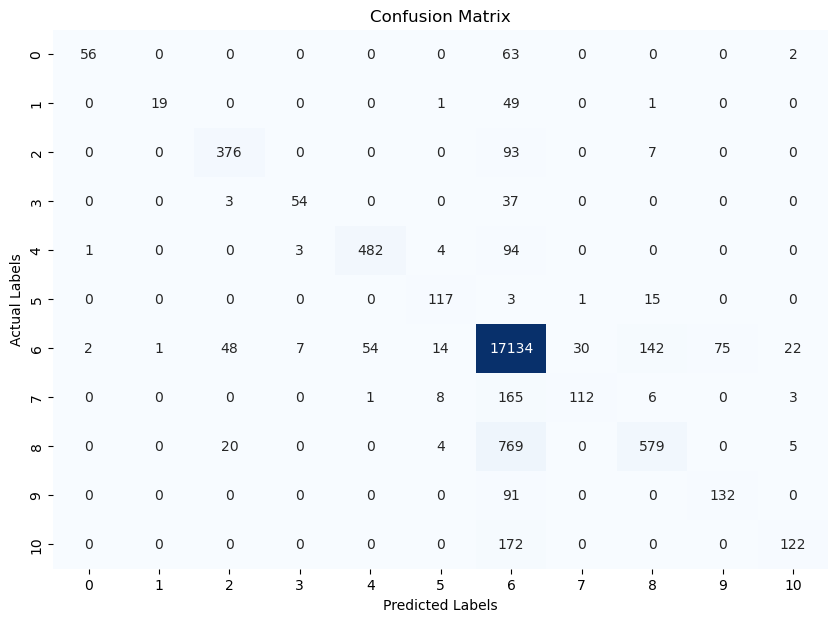

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(new_actual_labels, new_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [8]:
#                            precision    recall  f1-score   support

#                   B-Actor       0.00      0.00      0.00         2
#                 B-Airline       1.00      1.00      1.00         5
#                B-Airplane       0.29      0.11      0.16        18
#                 B-Airport       1.00      1.00      1.00         4
#               B-Algorithm       0.00      0.00      0.00         6
#                  B-Animal       0.77      0.37      0.50       130
#               B-Architect       0.00      0.00      0.00         2
#                  B-Artist       0.48      0.79      0.59        14
#                  B-Attack       1.00      0.14      0.25         7
#                  B-Author       1.00      0.24      0.39        25
#                   B-Award       0.93      0.82      0.87        17
#        B-Biological_Thing       0.00      0.00      0.00        47
#           B-Body_Of_Water       0.89      0.60      0.72        57
#               B-Body_Part       0.88      0.13      0.23        54
#       B-Broadcast_Network       0.00      0.00      0.00         1
#       B-Broadcast_Program       0.00      0.00      0.00         1
#                     B-Car       0.00      0.00      0.00         0
#          B-Chemical_Thing       0.66      0.58      0.62       241
#                    B-City       0.75      0.61      0.68       109
#                   B-Color       0.41      0.74      0.53        19
#                 B-Company       0.66      0.39      0.49        64
#                B-Computer       0.58      0.79      0.67        38
#                 B-Country       0.93      0.94      0.93       246
#                  B-County       0.00      0.00      0.00         3
#                B-Currency       0.75      0.79      0.77        19
#                    B-Date       0.70      0.67      0.69       239
#                B-Director       0.00      0.00      0.00         1
#                 B-Disease       0.00      0.00      0.00         0
#                  B-Doctor       1.00      0.67      0.80         3
#                    B-Drug       0.00      0.00      0.00         9
#      B-Educational_Degree       0.00      0.00      0.00         2
#  B-Educational_Department       0.00      0.00      0.00         5
# B-Educational_Institution       0.80      0.50      0.62         8
#                B-Election       0.75      0.60      0.67         5
#                  B-Engine       0.40      0.50      0.44         4
#                B-Engineer       0.04      1.00      0.08         1
#               B-Ethnicity       0.12      0.13      0.13        15
#                    B-Film       0.33      1.00      0.50         1
#                    B-Food       1.00      0.38      0.55        29
#                    B-Game       0.50      0.42      0.45        12
#                 B-Glacier       0.00      0.00      0.00         4
#                     B-God       1.00      1.00      1.00         6
#              B-Government       1.00      0.19      0.32        21
#       B-Government_Agency       0.33      0.08      0.12        13
#              B-Instrument       0.83      0.08      0.14        65
#                  B-Island       0.75      0.23      0.35        13
#                B-Language       0.82      0.93      0.87        69
#                     B-Law       0.60      0.92      0.73        13
#            B-Living_Thing       0.81      0.33      0.47        51
#                B-Military       1.00      0.45      0.62        11
#       B-Military_Conflict       0.88      0.56      0.68        27
#            B-Mobile_Phone       1.00      0.60      0.75         5
#                 B-Monarch       0.00      0.00      0.00         7
#                B-Mountain       1.00      0.14      0.25         7
#                   B-Music       0.56      0.31      0.40        16
#                B-Musician       0.00      0.00      0.00        16
#             B-Nationality       0.79      0.86      0.82       136
#        B-Natural_Disaster       0.00      0.00      0.00         1
#               B-Newspaper       1.00      1.00      1.00         1
#                    B-Play       0.00      0.00      0.00         5
#         B-Political_Party       0.25      0.20      0.22        20
#              B-Politician       1.00      0.71      0.83        56
#           B-Power_Station       0.00      0.00      0.00         4
#    B-Programming_Language       0.00      0.00      0.00         5
#                 B-Protest       1.00      0.50      0.67         2
#                B-Province       0.00      0.00      0.00         2
#                 B-Railway       0.00      0.00      0.00         2
#                B-Religion       0.82      0.87      0.84        31
#        B-Religious_Leader       1.00      0.33      0.50         9
#              B-Restaurant       1.00      0.75      0.86         4
#                    B-Road       0.00      0.00      0.00         0
#                    B-Ship       0.67      0.15      0.25        13
#                B-Software       1.00      0.50      0.67         8
#                 B-Soldier       0.00      0.00      0.00         1
#            B-Sports_Event       0.00      0.00      0.00         0
#         B-Sports_Facility       0.00      0.00      0.00         1
#        B-Terrorist_Attack       0.00      0.00      0.00         2
#                 B-Theater       0.00      0.00      0.00        22
#                    B-Time       0.71      0.19      0.31       103
#                   B-Title       0.00      0.00      0.00        29
#                   B-Train       0.00      0.00      0.00         1
#                  B-Weapon       1.00      0.13      0.24        15
#                 B-Website       0.00      0.00      0.00         3
#            B-Written_Work       0.71      0.24      0.36        21
#                 I-Airline       1.00      1.00      1.00        10
#                I-Airplane       1.00      0.56      0.71         9
#                 I-Airport       1.00      1.00      1.00        12
#               I-Algorithm       0.00      0.00      0.00         2
#                  I-Animal       0.55      0.53      0.54        32
#               I-Architect       0.00      0.00      0.00         1
#                  I-Artist       0.52      0.94      0.67        18
#                  I-Attack       0.67      0.33      0.44         6
#                  I-Author       1.00      0.27      0.42        15
#                   I-Award       0.71      0.48      0.57        21
#        I-Biological_Thing       0.00      0.00      0.00        47
#           I-Body_Of_Water       0.91      0.82      0.86        39
#               I-Body_Part       1.00      0.20      0.33         5
#       I-Broadcast_Network       0.00      0.00      0.00         1
#       I-Broadcast_Program       0.00      0.00      0.00         2
#          I-Chemical_Thing       0.90      0.52      0.66       107
#                    I-City       0.50      0.33      0.40         9
#                   I-Color       0.00      0.00      0.00         1
#                 I-Company       0.93      0.29      0.44        49
#                I-Computer       0.55      0.50      0.52        36
#                 I-Country       0.84      0.83      0.83        69
#                  I-County       0.00      0.00      0.00         1
#                I-Currency       0.67      0.71      0.69        14
#                    I-Date       0.78      0.72      0.75       237
#                I-Director       0.00      0.00      0.00         1
#                  I-Doctor       1.00      1.00      1.00         1
#                    I-Drug       0.00      0.00      0.00         2
#      I-Educational_Degree       0.00      0.00      0.00         0
#  I-Educational_Department       0.00      0.00      0.00         2
# I-Educational_Institution       0.80      0.33      0.47        12
#                I-Election       0.67      0.40      0.50         5
#                  I-Engine       0.25      1.00      0.40         1
#                I-Engineer       0.03      1.00      0.06         1
#               I-Ethnicity       0.25      1.00      0.40         1
#                    I-Film       0.67      1.00      0.80         2
#                    I-Food       1.00      0.25      0.40        16
#                    I-Game       0.00      0.00      0.00         2
#                 I-Glacier       0.00      0.00      0.00         4
#              I-Government       0.00      0.00      0.00        13
#       I-Government_Agency       0.50      0.10      0.16        21
#              I-Instrument       0.67      0.09      0.15        47
#                  I-Island       0.67      0.33      0.44         6
#                I-Language       0.62      0.62      0.62         8
#                     I-Law       0.77      0.91      0.83        11
#            I-Living_Thing       0.00      0.00      0.00        12
#                I-Military       1.00      0.36      0.53        14
#       I-Military_Conflict       0.89      0.68      0.77        37
#            I-Mobile_Phone       1.00      0.50      0.67         4
#                 I-Monarch       0.25      0.20      0.22         5
#                I-Mountain       0.00      0.00      0.00         5
#                   I-Music       1.00      0.57      0.72        30
#                I-Musician       0.00      0.00      0.00         2
#        I-Natural_Disaster       0.00      0.00      0.00         0
#               I-Newspaper       1.00      1.00      1.00         1
#                    I-Play       0.00      0.00      0.00         7
#         I-Political_Party       0.35      0.33      0.34        27
#              I-Politician       0.96      0.65      0.78        40
#           I-Power_Station       0.00      0.00      0.00        11
#    I-Programming_Language       0.00      0.00      0.00         1
#                 I-Protest       1.00      1.00      1.00         2
#                I-Province       0.00      0.00      0.00         2
#                 I-Railway       0.00      0.00      0.00         6
#                I-Religion       0.00      0.00      0.00         2
#        I-Religious_Leader       0.00      0.00      0.00         1
#                    I-Ship       0.00      0.00      0.00         5
#                I-Software       0.50      0.40      0.44         5
#                 I-Soldier       0.00      0.00      0.00         1
#            I-Sports_Event       0.00      0.00      0.00         0
#         I-Sports_Facility       0.00      0.00      0.00         2
#                 I-Theater       0.00      0.00      0.00        10
#                    I-Time       0.71      0.09      0.16       185
#                   I-Title       0.00      0.00      0.00         6
#                  I-Weapon       1.00      0.17      0.29         6
#                 I-Website       0.00      0.00      0.00         1
#            I-Written_Work       1.00      0.49      0.65        37
#                   OUTSIDE       0.92      0.98      0.95     17529

#                  accuracy                           0.89     21199
#                 macro avg       0.46      0.34      0.34     21199
#              weighted avg       0.88      0.89      0.88     21199

